# <font color ='blue'>Zillow Clustering Project - Working Copy
    
<img src="zillow_logo.png" alt="Zillow Logo" title="Zillow Logo" width="300" height="100" align="right"/>
    
    
# <p style="font-size:50px" align="center">Zestimate Error</p> <sub>By Kaniela Denis - 13 Dec 2021</sub>

In [1]:
# import pandas and numpy to start coding
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# prep methods
from sklearn.model_selection import train_test_split

# Scaler
from sklearn.preprocessing import MinMaxScaler

# cluster method
from sklearn.cluster import KMeans

# Feature Engineering methods
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing

# Modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

import warnings
warnings.filterwarnings("ignore")

<hr style="border:2px solid blue"> </hr>

# <font color = 'red'>Planning

### Project Goals

- Predict logerror of Zestimate
- Discover the drivers of the error in the Zcestimate
- Compare four different clustering models
- Conclude if clustering helps with discovering drivers
- 


- A model that predicts property tax assessed values of single family properties based on 2017 transactions.
- Identify ways to make a better model for Zillow.
- Create new features out of existing features.
- Try non-linear regression model or try a model for each county.


### Project Description

Deliver:
1. Github Repo
    - README.md
    - Final Report
    - Working Notebook
    - Modules (Acquire, Prepare, Model)
    - Misc Artifacts
2. Further Requirements:
    - Aquistion:
        - SQL Query
    - Prep:
        - Columns have appropriate Data Types
        - Missing values and Outliers are investigated/handled
    - Explore:
        - Use vizulization and statistical testing for target/independ variable interations
        - Clustering is used to explore the data. Minumum of 3 combinations of features tried. A conclusion is made on whether clustering helped, supported by visualizations and statistical testing.
    - Modeling: 
        - Minimum 4 different models created and performance compared
3. Final Notebook with Recommendation
    - 4 Visuals, 2 with stats tests
        - Data Context of Target Variable (Distribution of values)
    - 3 Best Models (show steps/code to fit/eval/select)
    - Visual of how best Model performed
4. Working Notebook:
    - Reproducible comments
    - Exploration with at least two stats test during exploration
5. Presentation
    - Findings
    - Methodologies
    - Conclusions

### Initial Questions

- What are the transactions are in 2017?
- What states and counties are the properties located in?
- What is the tax rate per county or fips? (might have to combine columns to calcualate)
- What is the distribution of tax rates for each county?
- What is the distribution of taxes across fips?
- What are the drivers of single family property values?
- Why do some properties have a much higher value than others when they are located so close to each other?
- Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? 
- Is having 1 bathroom worse than having 2 bedrooms?

### Data Dictionary (Add to README)

In [2]:
# Read Data Dictionary from working directory
dd = pd.read_excel('zillow_data_dictionary.xlsx')
dd

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (i...
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, ..."
2,'basementsqft',Finished living area below or partially below...
3,'bathroomcnt',Number of bathrooms in home including fractio...
4,'bedroomcnt',Number of bedrooms in home
5,'buildingqualitytypeid',Overall assessment of condition of the buildi...
6,'buildingclasstypeid',"The building framing type (steel frame, wood f..."
7,'calculatedbathnbr',Number of bathrooms in home including fractio...
8,'decktypeid',Type of deck (if any) present on parcel
9,'threequarterbathnbr',Number of 3/4 bathrooms in house (shower + si...


In [3]:
## References are available on my GitHub 

In [4]:
#[click me](https://github.com/kanieladenis/zillow_regression_project)

# <font color = 'red'> Acquisition (Get and Clean Data)

## <font color = 'red'>Get Data

- Added env.py to the repo .gitignore file so env.py won't be pushed to github
- Created an env file that contains my username, password, and host address fo the MySQL Server.

In [5]:
# import env file for hostname, username, password, and db_name
from env import host, user, password, db_name

In [6]:
# Pass env file authentication to container 'url'
url = f'mysql+pymysql://{user}:{password}@{host}/{db_name}'

### Pull records of houses with transactions from 2017

In [7]:
# define sql search for all records from all tables
sql = """
SELECT prop.*,
       pred.logerror, 
       pred.transactiondate, 
       air.airconditioningdesc, 
       arch.architecturalstyledesc, 
       build.buildingclassdesc, 
       heat.heatingorsystemdesc, 
       landuse.propertylandusedesc, 
       story.storydesc, 
       construct.typeconstructiondesc 
FROM   properties_2017 prop  
JOIN (SELECT parcelid,
                  logerror,
                  Max(transactiondate) transactiondate 
           FROM   predictions_2017 
           GROUP  BY parcelid, logerror) pred
       USING (parcelid)
JOIN propertylandusetype USING (propertylandusetypeid)
LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
LEFT JOIN storytype story USING (storytypeid) 
LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 
WHERE  prop.latitude IS NOT NULL 
AND prop.longitude IS NOT NULL
AND transactiondate < '2018-01-01' 
AND propertylandusetypeid = 261 
"""

### Note:
- ????

### Create Dataframe

In [8]:
# load zillow data from saved csv or pull from sql server and save to csv
import os
file = 'zillow_data_kan.csv'
if os.path.isfile(file):
    df = pd.read_csv(file, index_col=0)
else:
    df = pd.read_sql(sql,url)
    df.to_csv(file)
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,781532,12095076,1.0,NaN,NaN,3.0,4.0,NaN,9.0,3.0,...,6.037461e+13,-0.001011,2017-01-01,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN


### Show df info()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52438 entries, 0 to 52437
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52438 non-null  int64  
 1   parcelid                      52438 non-null  int64  
 2   airconditioningtypeid         13638 non-null  float64
 3   architecturalstyletypeid      70 non-null     float64
 4   basementsqft                  47 non-null     float64
 5   bathroomcnt                   52438 non-null  float64
 6   bedroomcnt                    52438 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         33739 non-null  float64
 9   calculatedbathnbr             52301 non-null  float64
 10  decktypeid                    389 non-null    float64
 11  finishedfloor1squarefeet      4379 non-null   float64
 12  calculatedfinishedsquarefeet  52356 non-null  float64
 13  f

In [10]:
# df shape
df.shape

(52438, 68)

In [11]:
# Show duplicated observations even with SQL filter
df.parcelid.duplicated().sum()

118

In [12]:
# Sort df by parcelid and then by transaction date to group by parcelid and to make sure transaction date is last
df = df.sort_values(by=['parcelid','transactiondate'])
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
37223,1087254,10711855,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,6.037113e+13,-0.007357,2017-07-07,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
48246,1072280,10711877,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,0.021066,2017-08-29,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
15536,1340933,10711888,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,0.077174,2017-04-04,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
12106,1878109,10711910,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,6.037113e+13,-0.041238,2017-03-17,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
13666,2190858,10711923,NaN,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,-0.009496,2017-03-24,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [13]:
# Show duplicated parcel id
df[df.duplicated(subset='parcelid', keep=False)].head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
9384,16179,10722858,NaN,NaN,NaN,2.0,4.0,NaN,6.0,2.0,...,6.037135e+13,0.095171,2017-03-02,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
9385,16179,10722858,NaN,NaN,NaN,2.0,4.0,NaN,6.0,2.0,...,6.037135e+13,-0.172843,2017-07-28,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
9306,1836115,10732347,NaN,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037137e+13,0.077198,2017-03-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
9307,1836115,10732347,NaN,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037137e+13,-0.221145,2017-07-25,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
1940,2119208,10739478,1.0,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037800e+13,0.083280,2017-01-13,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [14]:
# drop dulicates  but keep last transaction date
df = df.drop_duplicates(subset='parcelid', keep='last')

In [15]:
# Show duplicated parcel id
df[df.duplicated(subset='parcelid', keep=False)].head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc


In [16]:
# confirm duplicated parcel id removed
df.parcelid.duplicated().sum()

0

In [17]:
# check new shape
df.shape

(52320, 68)

In [18]:
# Replace blank values with NaN
df = df.replace('',np.nan)

In [19]:
# check if long/lat columns have nulls
df.longitude.isnull().sum(), df.latitude.isnull().sum()

(0, 0)

In [20]:
# number of nulls per column
df.isna().sum()

id                              0
parcelid                        0
airconditioningtypeid       38705
architecturalstyletypeid    52250
basementsqft                52273
                            ...  
buildingclassdesc           52320
heatingorsystemdesc         18470
propertylandusedesc             0
storydesc                   52273
typeconstructiondesc        52244
Length: 68, dtype: int64

In [21]:
# percent of nulls per column
df.isna().mean()

id                          0.000000
parcelid                    0.000000
airconditioningtypeid       0.739774
architecturalstyletypeid    0.998662
basementsqft                0.999102
                              ...   
buildingclassdesc           1.000000
heatingorsystemdesc         0.353020
propertylandusedesc         0.000000
storydesc                   0.999102
typeconstructiondesc        0.998547
Length: 68, dtype: float64

In [22]:
# number of nulls per row
df.isna().sum(axis=1)

37223    31
48246    29
15536    31
12106    31
13666    31
         ..
42306    35
31148    36
23911    36
9001     48
28113    48
Length: 52320, dtype: int64

In [23]:
# number of rows with a specific number of nulls
df.isna().sum(axis=1).value_counts()

33    11967
34    11158
32     8885
31     5989
36     4138
35     3469
29     2527
30     2199
37     1020
28      390
38      223
27      177
44       46
26       30
39       29
40       15
24       12
25       11
43       10
42        7
45        6
41        6
23        2
48        2
46        1
47        1
dtype: int64

In [24]:
# create dataframe that has column name as first column
col_nulls = pd.DataFrame()
col_nulls['columns_name'] = df.isna().sum().index
col_nulls

,columns_name
0,id
1,parcelid
2,airconditioningtypeid
3,architecturalstyletypeid
4,basementsqft
...,...
63,buildingclassdesc
64,heatingorsystemdesc
65,propertylandusedesc
66,storydesc


In [25]:
# create new column that hold the sum of nulls from each column
col_nulls['row_null_count'] = df.isna().sum().values
col_nulls

,columns_name,row_null_count
0,id,0
1,parcelid,0
2,airconditioningtypeid,38705
3,architecturalstyletypeid,52250
4,basementsqft,52273
...,...,...
63,buildingclassdesc,52320
64,heatingorsystemdesc,18470
65,propertylandusedesc,0
66,storydesc,52273


In [26]:
# create new column that hold the average of nulls from each column
col_nulls['row_null_percent'] = df.isna().mean().values
col_nulls

,columns_name,row_null_count,row_null_percent
0,id,0,0.000000
1,parcelid,0,0.000000
2,airconditioningtypeid,38705,0.739774
3,architecturalstyletypeid,52250,0.998662
4,basementsqft,52273,0.999102
...,...,...,...
63,buildingclassdesc,52320,1.000000
64,heatingorsystemdesc,18470,0.353020
65,propertylandusedesc,0,0.000000
66,storydesc,52273,0.999102


In [27]:
# sort values by percent
col_nulls = col_nulls.sort_values(by=['row_null_percent'], ascending=False)
col_nulls

,columns_name,row_null_count,row_null_percent
63,buildingclassdesc,52320,1.000000
7,buildingclasstypeid,52320,1.000000
15,finishedsquarefeet15,52320,1.000000
14,finishedsquarefeet13,52320,1.000000
42,storytypeid,52273,0.999102
...,...,...,...
25,latitude,0,0.000000
18,fips,0,0.000000
6,bedroomcnt,0,0.000000
5,bathroomcnt,0,0.000000


In [28]:
# shows column nulls in each row
row_nulls = pd.DataFrame(df.isnull().sum(axis=1), columns=['row_nulls'])
row_nulls.head()

,row_nulls
37223,31
48246,29
15536,31
12106,31
13666,31


In [29]:
# shows index as id
row_nulls = row_nulls.reset_index()
row_nulls.head()

,index,row_nulls
0,37223,31
1,48246,29
2,15536,31
3,12106,31
4,13666,31


In [30]:
# Create df with number of rows with a specific number of null columns
row_nulls = pd.DataFrame(df.isna().sum(axis=1).value_counts(), columns=['num_rows_with_n_null_cols'])
row_nulls.head()

,num_rows_with_n_null_cols
33,11967
34,11158
32,8885
31,5989
36,4138


In [31]:
# make first columnb the number of nulls
row_nulls = row_nulls.reset_index()
row_nulls.head()

,index,num_rows_with_n_null_cols
0,33,11967
1,34,11158
2,32,8885
3,31,5989
4,36,4138


In [32]:
# rename index to match values
row_nulls = row_nulls.rename(columns={'index':'n_null_cols'})
row_nulls.head()

,n_null_cols,num_rows_with_n_null_cols
0,33,11967
1,34,11158
2,32,8885
3,31,5989
4,36,4138


In [33]:
# create columsn for percent of null cols
row_nulls['percent_null_cols'] = row_nulls.n_null_cols / df.shape[1]
row_nulls.head()

,n_null_cols,num_rows_with_n_null_cols,percent_null_cols
0,33,11967,0.485294
1,34,11158,0.500000
2,32,8885,0.470588
3,31,5989,0.455882
4,36,4138,0.529412


In [34]:
# sort df by percentn of null cols
row_nulls = row_nulls.sort_values(by=['percent_null_cols'], ascending=False)
row_nulls

,n_null_cols,num_rows_with_n_null_cols,percent_null_cols
23,48,2,0.705882
25,47,1,0.691176
24,46,1,0.676471
20,45,6,0.661765
12,44,46,0.647059
18,43,10,0.632353
19,42,7,0.617647
21,41,6,0.602941
15,40,15,0.588235
14,39,29,0.573529


# <font color = 'red'>Prepare

In [35]:
# show value counts for each column, does not include nulls
for col in df.columns:
    print(f'-------------{col}-----------------')
    print(df[df[col].notna()][col].value_counts(dropna=False))

-------------id-----------------
2232322    1
2324100    1
151139     1
949861     1
2538363    1
          ..
738319     1
115949     1
1692911    1
2960624    1
657407     1
Name: id, Length: 52320, dtype: int64
-------------parcelid-----------------
10913809    1
14004381    1
12888190    1
14243968    1
11227265    1
           ..
14147054    1
13096431    1
12660208    1
12789233    1
12853244    1
Name: parcelid, Length: 52320, dtype: int64
-------------airconditioningtypeid-----------------
1.0     11873
13.0     1567
5.0       159
11.0       16
Name: airconditioningtypeid, dtype: int64
-------------architecturalstyletypeid-----------------
7.0     62
3.0      3
2.0      2
21.0     2
8.0      1
Name: architecturalstyletypeid, dtype: int64
-------------basementsqft-----------------
273.0     2
515.0     2
100.0     2
900.0     2
912.0     2
640.0     2
352.0     1
90.0      1
300.0     1
588.0     1
1252.0    1
280.0     1
384.0     1
3560.0    1
396.0     1
1969.0    1
252.0    

Central       20689
Floor/Wall    12527
Forced air      517
Solar            85
None             16
Baseboard         7
Radiant           6
Gravity           2
Yes               1
Name: heatingorsystemdesc, dtype: int64
-------------propertylandusedesc-----------------
Single Family Residential    52320
Name: propertylandusedesc, dtype: int64
-------------storydesc-----------------
Basement    47
Name: storydesc, dtype: int64
-------------typeconstructiondesc-----------------
Frame       75
Concrete     1
Name: typeconstructiondesc, dtype: int64


In [36]:
# remove propeties that have no bedrooms and no bathrooms and too small of an area
df = df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0) & (df.unitcnt <= 1) | df.unitcnt.isna() & (df.calculatedfinishedsquarefeet > 500) & (df.bedroomcnt > 0) & (df.bathroomcnt > 0)]

In [37]:
df.shape

(52115, 68)

In [38]:
# set threshhold for number of non-null rows in each column to determine drop
thresh_col = .5 * df.shape[0]
thresh_col

26057.5

In [39]:
# drop columns that meet null-rows threshhold
df = df.dropna(axis=1, thresh=thresh_col)
df.shape

(52115, 34)

In [40]:
# set threshhold for number of non-null columns each row must to determine drop
thresh_row = .7 * df.shape[1]
thresh_row

23.799999999999997

In [41]:
df = df.dropna(axis=0, thresh=thresh_row)
df.shape

(52115, 34)

In [42]:
def handle_missing_values(df, percent_required_cols = .5, percent_required_rows = .7):
    
    # set threshold for min of values in columns for dropping
    thresh_col = int(round(percent_required_cols * df.shape[0]))
    
    # drop columns that don't meed threshhold for non-null values (rows without nulls)
    df = df.dropna(axis=1, thresh=thresh_col)
    
    # set threshold for min non-null values for rows (cols without nulls)
    thresh_row = int(round(percent_required_rows * df.shape[1]))
    
    # drop rows with don't meet threshold for non-null values for columns
    df = df.dropna(axis=0, thresh=thresh_row)
    
    return df, thresh_col, thresh_row,

In [43]:
# Run fucntion to remove columns and rows that meet thresh hold
df, thresh_col, thresh_row  = handle_missing_values(df, percent_required_cols = .5, percent_required_rows = .5)

In [44]:
# see new df shape, 
df.shape, thresh_col, thresh_row

((52115, 34), 26058, 17)

### Deal with the rest of the nulls

In [45]:
df.isna().sum()

id                                  0
parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           18510
calculatedbathnbr                  15
calculatedfinishedsquarefeet        0
finishedsquarefeet12              153
fips                                0
fullbathcnt                        15
heatingorsystemtypeid           18307
latitude                            0
longitude                           0
lotsizesquarefeet                 350
propertycountylandusecode           0
propertylandusetypeid               0
propertyzoningdesc              18449
rawcensustractandblock              0
regionidcity                     1028
regionidcounty                      0
regionidzip                        23
roomcnt                             0
unitcnt                         18424
yearbuilt                          33
structuretaxvaluedollarcnt         69
taxvaluedollarcnt                   1
assessmentye

### Dropping Unneeded Columns:
- parcel id, id, popertylandusetype, unitcnt: no longer needed after data filtering
- propertyzoningdesc, finishedsquarefeet12, censustracdtandblock, rawcensustracdtandblock, heatingorsystemtupeid, assessmentyear, transactiondate: Not useful

In [46]:
# remove columns that are not useful
df = df.drop(columns=[
    # uniquie identifer to lot
    'parcelid',
    # uniquie identifer for table        
    'id',
     #Description of the allowed land uses (zoning) for that property
     'propertyzoningdesc', 
     # Finished living area
     'finishedsquarefeet12',
     #  Census tract and block ID combined - also contains blockgroup assignment by extension
         'censustractandblock',
      # Type of land use the property is zoned for
      'propertylandusetypeid',
      #  Type of home heating system
      'heatingorsystemtypeid',
    # unit type cnt: filtered out to only 1 cnt, no longer needed
    'unitcnt',
    # Census tract and block ID combined, not needed
    'rawcensustractandblock',
    # year assessed
    'assessmentyear',
    # date of transaction
    'transactiondate',
    #  Number of bathrooms in home including fractional bathroom. duplicate from bathroomcnt
    'calculatedbathnbr',
    #  Total number of rooms in the principal residence. Not collected for LA County
    'roomcnt',
    # descirpiton of land use (single family), no longer needed
    'propertylandusedesc'
    
    ])

In [47]:
df.shape

(52115, 20)

In [48]:
# check value counts for heating systems
df.heatingorsystemdesc.value_counts(dropna=False)

Central       20670
NaN           18307
Floor/Wall    12504
Forced air      517
Solar            85
None             16
Baseboard         7
Radiant           6
Gravity           2
Yes               1
Name: heatingorsystemdesc, dtype: int64

In [49]:
# check value counts for heating sytems in LA
df[df.fips == 6037].heatingorsystemdesc.value_counts(dropna=False)

Central       20670
Floor/Wall    12475
NaN             498
Solar            85
Name: heatingorsystemdesc, dtype: int64

In [50]:
# check value counts for heating sytems in OC
df[df.fips == 6059].heatingorsystemdesc.value_counts(dropna=False)

NaN           13463
Forced air      517
Floor/Wall       29
None             16
Baseboard         7
Radiant           6
Gravity           2
Yes               1
Name: heatingorsystemdesc, dtype: int64

In [51]:
# check value counts for heating sytems in Ventura
df[df.fips == 6111].heatingorsystemdesc.value_counts(dropna=False)

NaN    4346
Name: heatingorsystemdesc, dtype: int64

In [52]:
# relacing nulls with 'None', assuming null was for not having a heating system
df.heatingorsystemdesc.fillna('None', inplace=True)

In [53]:
# checking nulls were removed
df.heatingorsystemdesc.isna().sum()

0

In [54]:
# checking building quality type id for LA
df[df.fips == 6037].buildingqualitytypeid.value_counts(dropna=False)

6.0     10250
8.0      8218
4.0      8125
7.0      3419
5.0      1495
9.0      1118
11.0      514
10.0      228
3.0       147
NaN       123
12.0       80
1.0         8
2.0         3
Name: buildingqualitytypeid, dtype: int64

In [55]:
# checking building quality type id for OC
df[df.fips == 6059].buildingqualitytypeid.value_counts(dropna=False)

NaN    14041
Name: buildingqualitytypeid, dtype: int64

In [56]:
# checking building quality type id for Vetura
df[df.fips == 6111].buildingqualitytypeid.value_counts(dropna=False)

NaN    4346
Name: buildingqualitytypeid, dtype: int64

### Looks like building quality type was not collected for OC or Ventura. Dropping column.

In [57]:
# droping buildingqualitytypeid because they are not collected for Ventura and Orange
df.drop(columns=['buildingqualitytypeid'], inplace=True)

In [58]:
df.shape

(52115, 19)

In [59]:
df.isna().sum()

bathroomcnt                        0
bedroomcnt                         0
calculatedfinishedsquarefeet       0
fips                               0
fullbathcnt                       15
latitude                           0
longitude                          0
lotsizesquarefeet                350
propertycountylandusecode          0
regionidcity                    1028
regionidcounty                     0
regionidzip                       23
yearbuilt                         33
structuretaxvaluedollarcnt        69
taxvaluedollarcnt                  1
landtaxvaluedollarcnt              1
taxamount                          4
logerror                           0
heatingorsystemdesc                0
dtype: int64

In [60]:
# dropping the rest of the nulls
df.dropna(inplace=True)

In [61]:
df.isna().sum()

bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
logerror                        0
heatingorsystemdesc             0
dtype: int64

## Remove Outliers

In [62]:
# List of columns
cols = [col for col in df.columns.drop(['bedroomcnt',
                                        'fips',
                                        'propertycountylandusecode',
                                        'heatingorsystemdesc'
                                       ])]
cols

['bathroomcnt',
 'calculatedfinishedsquarefeet',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'logerror']

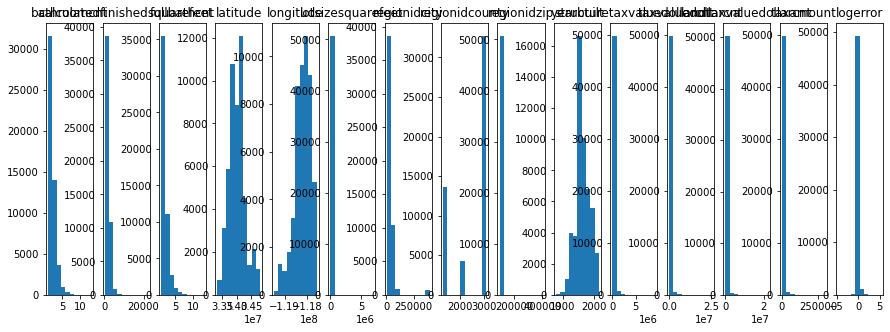

In [63]:
plt.figure(figsize=(15, 5))

for i, col in enumerate(cols,1):

    # i starts at 0, but plot nos should start at 1
    plot_number = i

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist()

    # Hide gridlines.
    plt.grid()
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

In [64]:
df.shape

(50677, 19)

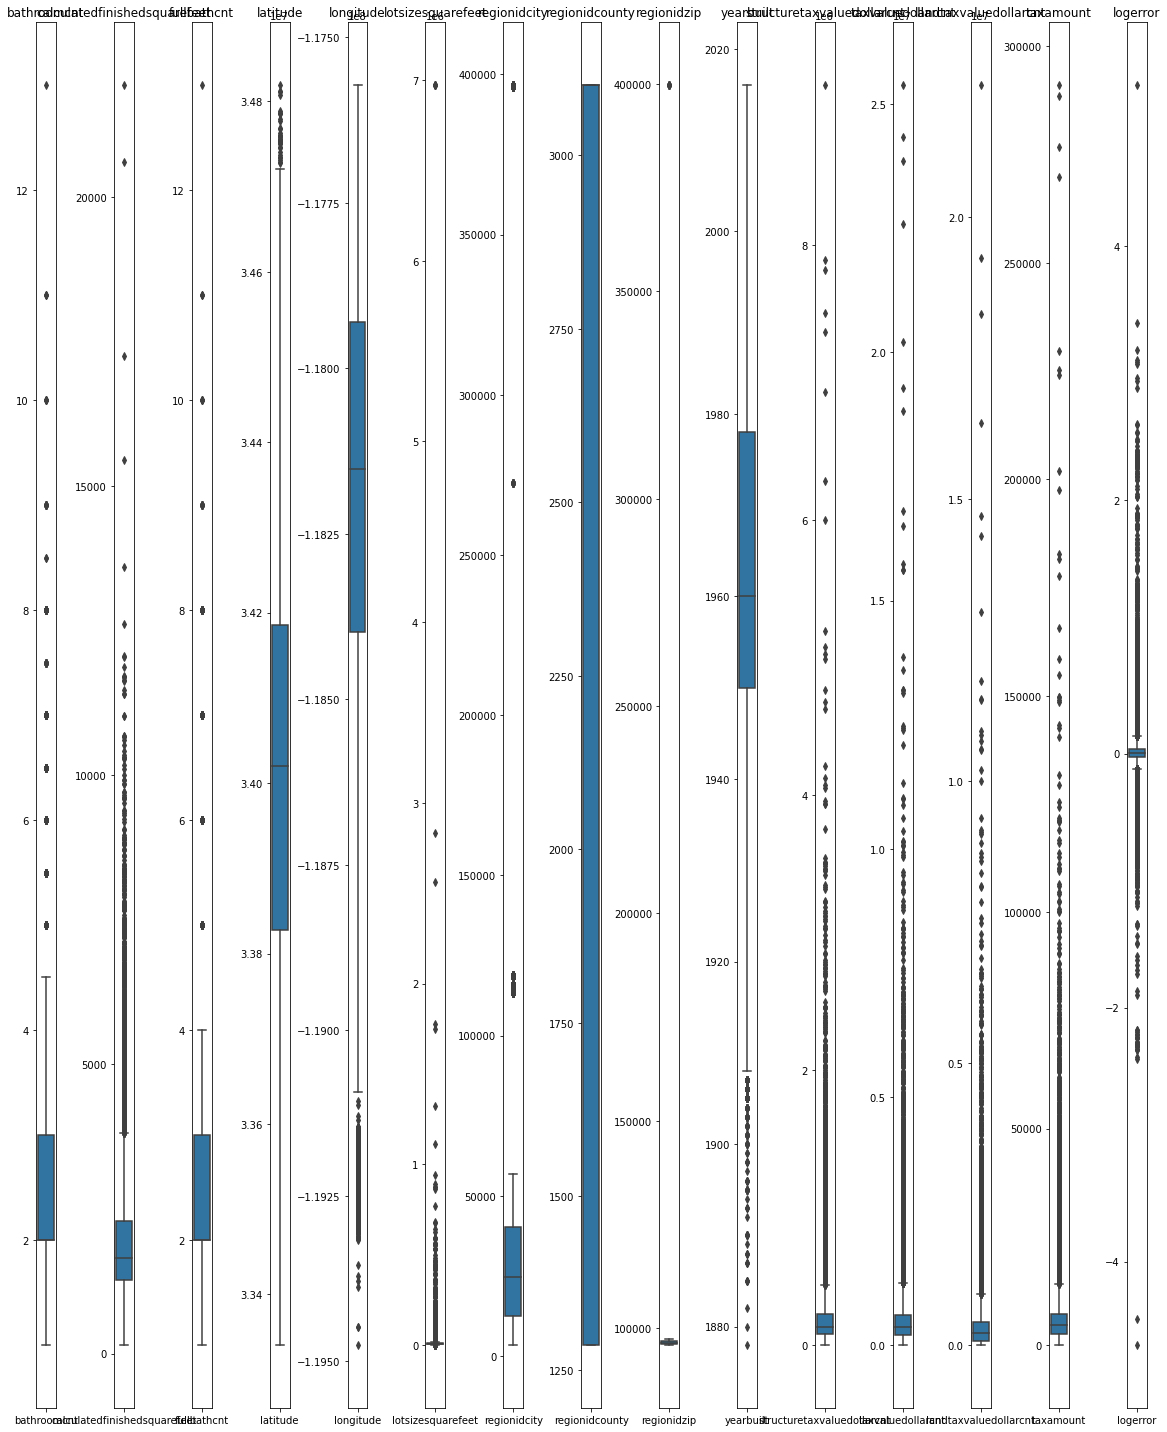

In [65]:
# List of columns
        
plt.figure(figsize=(16, 20))

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=df[[col]])

    # Hide gridlines.
    plt.grid(False)
    
    # sets proper spacing between plots
    plt.tight_layout()

plt.show()

In [66]:
# remove outliers from each column in cols_list
for col in cols:

    q1, q3 = df[col].quantile([.25, .75])  # get quartiles

    iqr = q3 - q1   # calculate interquartile range

    upper_bound = q3 + 1.5 * iqr   # get upper bound
    lower_bound = q1 - 1.5 * iqr   # get lower bound

    # return dataframe without outliers

    df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]

In [67]:
df.shape

(31456, 19)

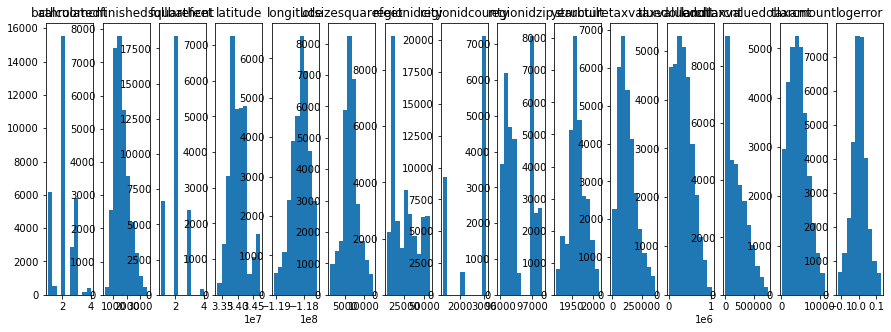

In [68]:
plt.figure(figsize=(15, 5))

for i, col in enumerate(cols,1):

    # i starts at 0, but plot nos should start at 1
    plot_number = i

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist()

    # Hide gridlines.
    plt.grid()
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

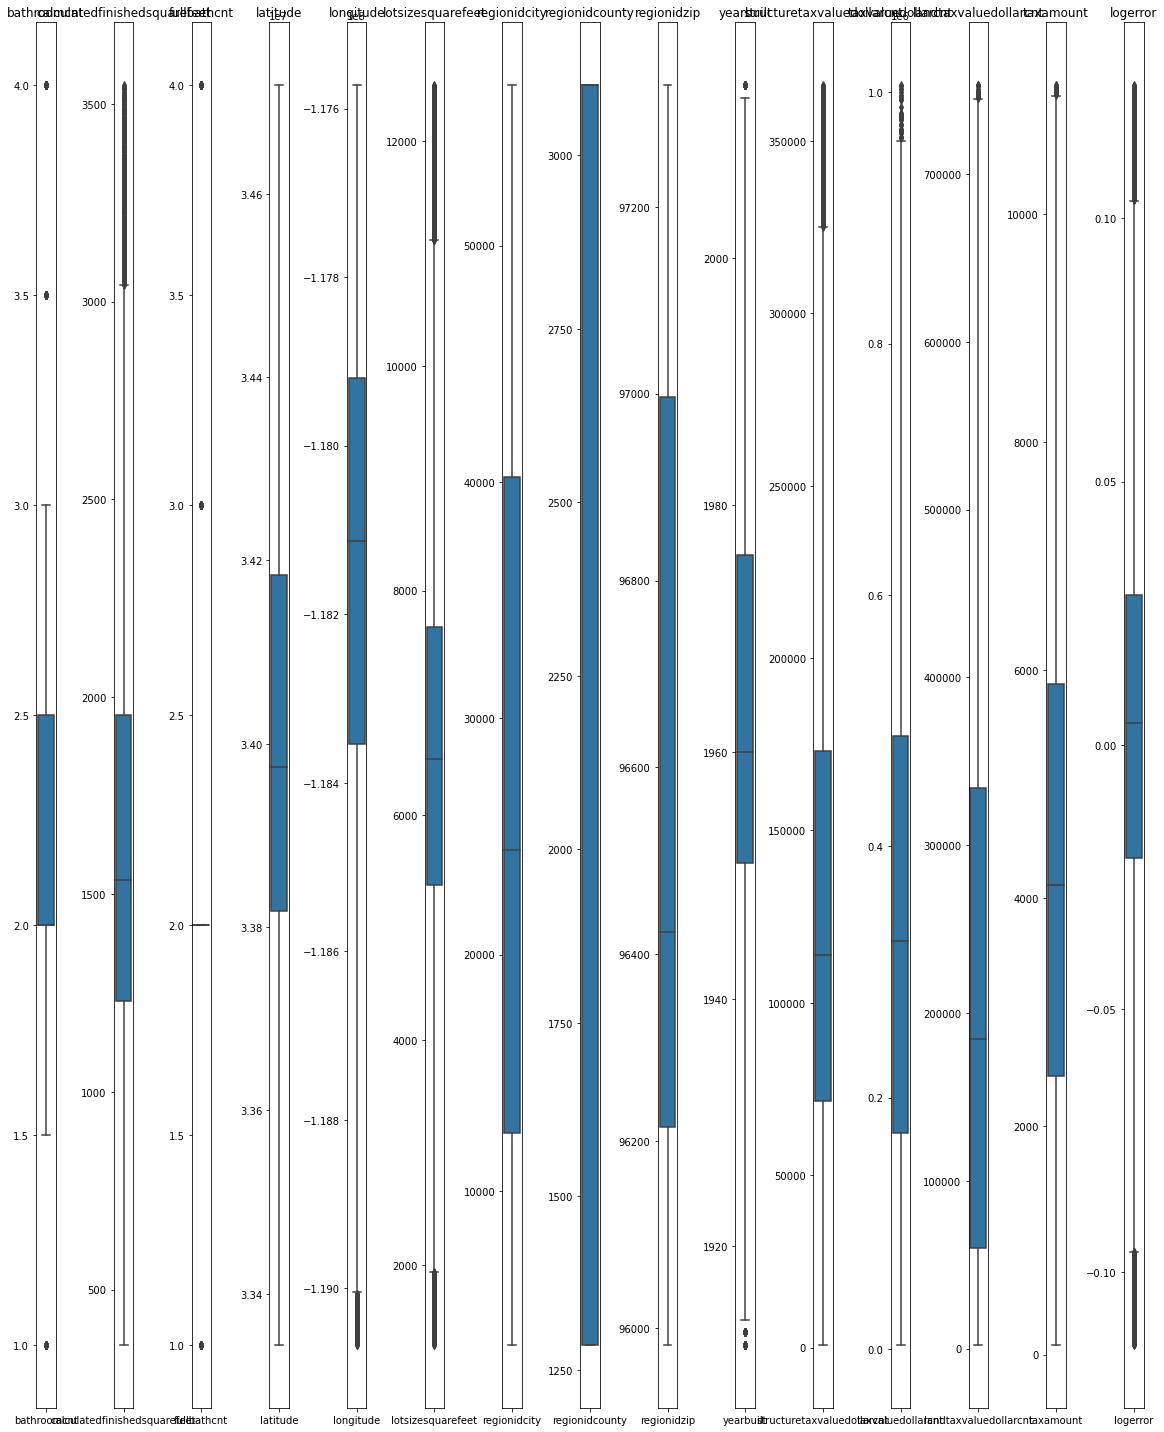

In [69]:
# List of columns
        
plt.figure(figsize=(16, 20))

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=df[[col]])

    # Hide gridlines.
    plt.grid(False)
    
    # sets proper spacing between plots
    plt.tight_layout()

plt.show()

## Rename for Readability

In [70]:
df.columns.to_list()

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'fips',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'propertycountylandusecode',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'logerror',
 'heatingorsystemdesc']

In [71]:
# rename for readability
df = df.rename(columns = {'bathroomcnt':'bathrooms',
 'bedroomcnt':'bedrooms',
 'calculatedfinishedsquarefeet':'house_area',
 'fullbathcnt':'full_baths',
 'lotsizesquarefeet':'lot_area',
 'propertycountylandusecode':'land_use_code',
 'regionidcity':'city_id',
 'regionidcounty':'county_id',
 'regionidzip':'zip_id',
 'yearbuilt':'year_built',
 'structuretaxvaluedollarcnt':'tax_value_house',
 'taxvaluedollarcnt':'tax_value_total',
 'landtaxvaluedollarcnt':'tax_value_land',
 'taxamount':'tax_amount',
 'heatingorsystemdesc':'heating_sys',
})

In [72]:
df.columns.to_list()

['bathrooms',
 'bedrooms',
 'house_area',
 'fips',
 'full_baths',
 'latitude',
 'longitude',
 'lot_area',
 'land_use_code',
 'city_id',
 'county_id',
 'zip_id',
 'year_built',
 'tax_value_house',
 'tax_value_total',
 'tax_value_land',
 'tax_amount',
 'logerror',
 'heating_sys']

## Add Columns: Age, Absolute LogError, County, HouseDolloarPerSqft, TaxRate, BedBath Ratio

In [73]:
# create column for age of house
df['age'] = 2017 - df.year_built
df.head()

,bathrooms,bedrooms,house_area,fips,full_baths,latitude,longitude,lot_area,land_use_code,city_id,county_id,zip_id,year_built,tax_value_house,tax_value_total,tax_value_land,tax_amount,logerror,heating_sys,age
37223,2.0,3.0,2107.0,6037.0,2.0,34222559.0,-118617387.0,9158.0,0101,12447.0,3101.0,96339.0,1972.0,249655.0,624139.0,374484.0,7659.36,-0.007357,Central,45.0
48246,2.0,4.0,1882.0,6037.0,2.0,34220261.0,-118616409.0,9035.0,0101,12447.0,3101.0,96339.0,1972.0,253000.0,660000.0,407000.0,8123.91,0.021066,Central,45.0
15536,2.0,4.0,1882.0,6037.0,2.0,34222491.0,-118616854.0,9800.0,0100,12447.0,3101.0,96339.0,1972.0,257591.0,542923.0,285332.0,6673.24,0.077174,Central,45.0
12106,2.0,3.0,1477.0,6037.0,2.0,34221864.0,-118615739.0,11285.0,0101,12447.0,3101.0,96339.0,1960.0,57968.0,78031.0,20063.0,1116.46,-0.041238,Central,57.0
13666,2.0,4.0,1918.0,6037.0,2.0,34220619.0,-118615253.0,11239.0,0101,12447.0,3101.0,96339.0,1960.0,167869.0,415459.0,247590.0,5239.85,-0.009496,Central,57.0


In [74]:
# Create column for absolute value of logerror
df['logerror_abs'] = df.logerror.abs()
df.head()

,bathrooms,bedrooms,house_area,fips,full_baths,latitude,longitude,lot_area,land_use_code,city_id,...,zip_id,year_built,tax_value_house,tax_value_total,tax_value_land,tax_amount,logerror,heating_sys,age,logerror_abs
37223,2.0,3.0,2107.0,6037.0,2.0,34222559.0,-118617387.0,9158.0,0101,12447.0,...,96339.0,1972.0,249655.0,624139.0,374484.0,7659.36,-0.007357,Central,45.0,0.007357
48246,2.0,4.0,1882.0,6037.0,2.0,34220261.0,-118616409.0,9035.0,0101,12447.0,...,96339.0,1972.0,253000.0,660000.0,407000.0,8123.91,0.021066,Central,45.0,0.021066
15536,2.0,4.0,1882.0,6037.0,2.0,34222491.0,-118616854.0,9800.0,0100,12447.0,...,96339.0,1972.0,257591.0,542923.0,285332.0,6673.24,0.077174,Central,45.0,0.077174
12106,2.0,3.0,1477.0,6037.0,2.0,34221864.0,-118615739.0,11285.0,0101,12447.0,...,96339.0,1960.0,57968.0,78031.0,20063.0,1116.46,-0.041238,Central,57.0,0.041238
13666,2.0,4.0,1918.0,6037.0,2.0,34220619.0,-118615253.0,11239.0,0101,12447.0,...,96339.0,1960.0,167869.0,415459.0,247590.0,5239.85,-0.009496,Central,57.0,0.009496


In [75]:
# create columsn to match fips to county(LA, Orange County, Ventury County)
df['county'] = df.fips.map({6037:'LA',
            6059:'OC',
            6111:'Ventura'})
df.head()

,bathrooms,bedrooms,house_area,fips,full_baths,latitude,longitude,lot_area,land_use_code,city_id,...,year_built,tax_value_house,tax_value_total,tax_value_land,tax_amount,logerror,heating_sys,age,logerror_abs,county
37223,2.0,3.0,2107.0,6037.0,2.0,34222559.0,-118617387.0,9158.0,0101,12447.0,...,1972.0,249655.0,624139.0,374484.0,7659.36,-0.007357,Central,45.0,0.007357,LA
48246,2.0,4.0,1882.0,6037.0,2.0,34220261.0,-118616409.0,9035.0,0101,12447.0,...,1972.0,253000.0,660000.0,407000.0,8123.91,0.021066,Central,45.0,0.021066,LA
15536,2.0,4.0,1882.0,6037.0,2.0,34222491.0,-118616854.0,9800.0,0100,12447.0,...,1972.0,257591.0,542923.0,285332.0,6673.24,0.077174,Central,45.0,0.077174,LA
12106,2.0,3.0,1477.0,6037.0,2.0,34221864.0,-118615739.0,11285.0,0101,12447.0,...,1960.0,57968.0,78031.0,20063.0,1116.46,-0.041238,Central,57.0,0.041238,LA
13666,2.0,4.0,1918.0,6037.0,2.0,34220619.0,-118615253.0,11239.0,0101,12447.0,...,1960.0,167869.0,415459.0,247590.0,5239.85,-0.009496,Central,57.0,0.009496,LA


In [76]:
# create column for Dollar per square foot
df['house_dollar_sqft'] = df.tax_value_total / df.house_area
df.head()

,bathrooms,bedrooms,house_area,fips,full_baths,latitude,longitude,lot_area,land_use_code,city_id,...,tax_value_house,tax_value_total,tax_value_land,tax_amount,logerror,heating_sys,age,logerror_abs,county,house_dollar_sqft
37223,2.0,3.0,2107.0,6037.0,2.0,34222559.0,-118617387.0,9158.0,0101,12447.0,...,249655.0,624139.0,374484.0,7659.36,-0.007357,Central,45.0,0.007357,LA,296.221642
48246,2.0,4.0,1882.0,6037.0,2.0,34220261.0,-118616409.0,9035.0,0101,12447.0,...,253000.0,660000.0,407000.0,8123.91,0.021066,Central,45.0,0.021066,LA,350.690755
15536,2.0,4.0,1882.0,6037.0,2.0,34222491.0,-118616854.0,9800.0,0100,12447.0,...,257591.0,542923.0,285332.0,6673.24,0.077174,Central,45.0,0.077174,LA,288.481934
12106,2.0,3.0,1477.0,6037.0,2.0,34221864.0,-118615739.0,11285.0,0101,12447.0,...,57968.0,78031.0,20063.0,1116.46,-0.041238,Central,57.0,0.041238,LA,52.830738
13666,2.0,4.0,1918.0,6037.0,2.0,34220619.0,-118615253.0,11239.0,0101,12447.0,...,167869.0,415459.0,247590.0,5239.85,-0.009496,Central,57.0,0.009496,LA,216.610532


In [77]:
# Create column for land dollar per sqft
df['land_dollar_sqft'] = df.tax_value_land / df.lot_area
df.head()

,bathrooms,bedrooms,house_area,fips,full_baths,latitude,longitude,lot_area,land_use_code,city_id,...,tax_value_total,tax_value_land,tax_amount,logerror,heating_sys,age,logerror_abs,county,house_dollar_sqft,land_dollar_sqft
37223,2.0,3.0,2107.0,6037.0,2.0,34222559.0,-118617387.0,9158.0,0101,12447.0,...,624139.0,374484.0,7659.36,-0.007357,Central,45.0,0.007357,LA,296.221642,40.891461
48246,2.0,4.0,1882.0,6037.0,2.0,34220261.0,-118616409.0,9035.0,0101,12447.0,...,660000.0,407000.0,8123.91,0.021066,Central,45.0,0.021066,LA,350.690755,45.047039
15536,2.0,4.0,1882.0,6037.0,2.0,34222491.0,-118616854.0,9800.0,0100,12447.0,...,542923.0,285332.0,6673.24,0.077174,Central,45.0,0.077174,LA,288.481934,29.115510
12106,2.0,3.0,1477.0,6037.0,2.0,34221864.0,-118615739.0,11285.0,0101,12447.0,...,78031.0,20063.0,1116.46,-0.041238,Central,57.0,0.041238,LA,52.830738,1.777847
13666,2.0,4.0,1918.0,6037.0,2.0,34220619.0,-118615253.0,11239.0,0101,12447.0,...,415459.0,247590.0,5239.85,-0.009496,Central,57.0,0.009496,LA,216.610532,22.029540


In [78]:
# create column for tax rate
df['tax_rate'] = df.tax_value_house / df.tax_amount
df.head()

,bathrooms,bedrooms,house_area,fips,full_baths,latitude,longitude,lot_area,land_use_code,city_id,...,tax_value_land,tax_amount,logerror,heating_sys,age,logerror_abs,county,house_dollar_sqft,land_dollar_sqft,tax_rate
37223,2.0,3.0,2107.0,6037.0,2.0,34222559.0,-118617387.0,9158.0,0101,12447.0,...,374484.0,7659.36,-0.007357,Central,45.0,0.007357,LA,296.221642,40.891461,32.594760
48246,2.0,4.0,1882.0,6037.0,2.0,34220261.0,-118616409.0,9035.0,0101,12447.0,...,407000.0,8123.91,0.021066,Central,45.0,0.021066,LA,350.690755,45.047039,31.142639
15536,2.0,4.0,1882.0,6037.0,2.0,34222491.0,-118616854.0,9800.0,0100,12447.0,...,285332.0,6673.24,0.077174,Central,45.0,0.077174,LA,288.481934,29.115510,38.600590
12106,2.0,3.0,1477.0,6037.0,2.0,34221864.0,-118615739.0,11285.0,0101,12447.0,...,20063.0,1116.46,-0.041238,Central,57.0,0.041238,LA,52.830738,1.777847,51.921251
13666,2.0,4.0,1918.0,6037.0,2.0,34220619.0,-118615253.0,11239.0,0101,12447.0,...,247590.0,5239.85,-0.009496,Central,57.0,0.009496,LA,216.610532,22.029540,32.036986


In [79]:
# create column for bed bath ratio
df['bed_bath_ration'] = df.bedrooms / df.bathrooms
df.head()

,bathrooms,bedrooms,house_area,fips,full_baths,latitude,longitude,lot_area,land_use_code,city_id,...,tax_amount,logerror,heating_sys,age,logerror_abs,county,house_dollar_sqft,land_dollar_sqft,tax_rate,bed_bath_ration
37223,2.0,3.0,2107.0,6037.0,2.0,34222559.0,-118617387.0,9158.0,0101,12447.0,...,7659.36,-0.007357,Central,45.0,0.007357,LA,296.221642,40.891461,32.594760,1.5
48246,2.0,4.0,1882.0,6037.0,2.0,34220261.0,-118616409.0,9035.0,0101,12447.0,...,8123.91,0.021066,Central,45.0,0.021066,LA,350.690755,45.047039,31.142639,2.0
15536,2.0,4.0,1882.0,6037.0,2.0,34222491.0,-118616854.0,9800.0,0100,12447.0,...,6673.24,0.077174,Central,45.0,0.077174,LA,288.481934,29.115510,38.600590,2.0
12106,2.0,3.0,1477.0,6037.0,2.0,34221864.0,-118615739.0,11285.0,0101,12447.0,...,1116.46,-0.041238,Central,57.0,0.041238,LA,52.830738,1.777847,51.921251,1.5
13666,2.0,4.0,1918.0,6037.0,2.0,34220619.0,-118615253.0,11239.0,0101,12447.0,...,5239.85,-0.009496,Central,57.0,0.009496,LA,216.610532,22.029540,32.036986,2.0


In [80]:
df.columns.to_list()

['bathrooms',
 'bedrooms',
 'house_area',
 'fips',
 'full_baths',
 'latitude',
 'longitude',
 'lot_area',
 'land_use_code',
 'city_id',
 'county_id',
 'zip_id',
 'year_built',
 'tax_value_house',
 'tax_value_total',
 'tax_value_land',
 'tax_amount',
 'logerror',
 'heating_sys',
 'age',
 'logerror_abs',
 'county',
 'house_dollar_sqft',
 'land_dollar_sqft',
 'tax_rate',
 'bed_bath_ration']

# <font color = 'red'>Split

In [81]:
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
train.shape, validate.shape, test.shape

((17614, 26), (7550, 26), (6292, 26))

# <font color = 'red'> Explore

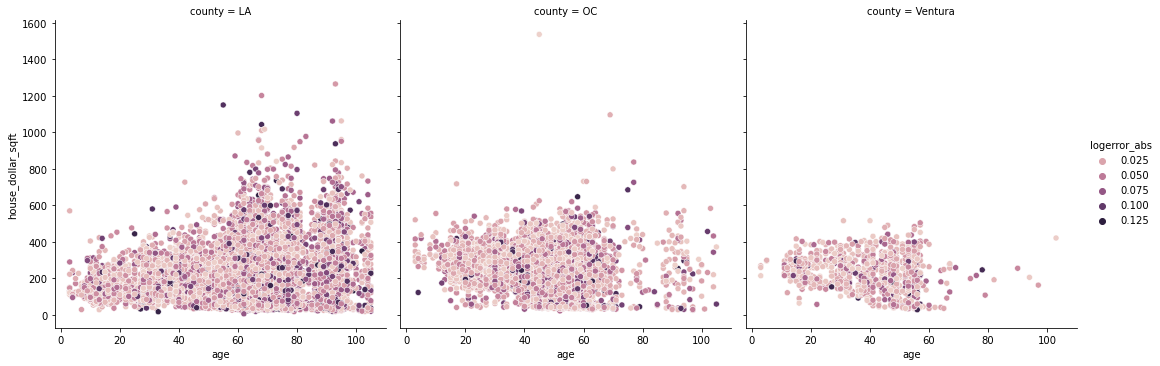

In [82]:
sns.relplot(data=train, x='age', y='house_dollar_sqft', hue='logerror_abs', col='county', kind='scatter')

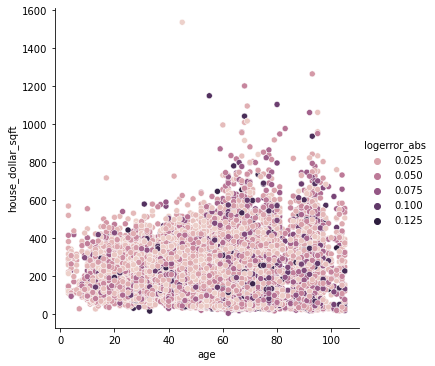

In [83]:
# plot without county
sns.relplot(data=train, x='age', y='house_dollar_sqft', hue='logerror_abs', kind='scatter')

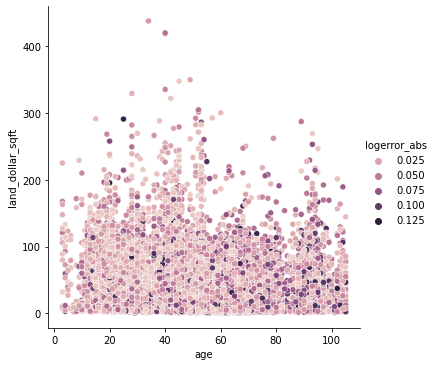

In [84]:
# show log error for age vs land dollar per sqft
sns.relplot(data=train, x='age', y='land_dollar_sqft', hue='logerror_abs', kind='scatter')

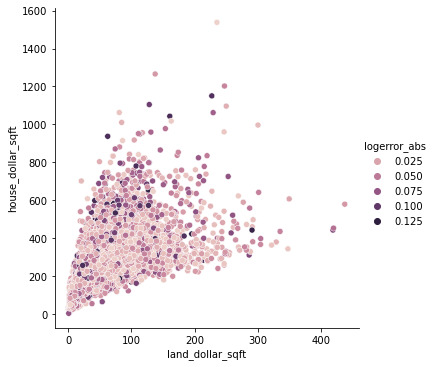

In [85]:
# show log error for age vs land dollar per sqft
sns.relplot(data=train, x='land_dollar_sqft', y='house_dollar_sqft', hue='logerror_abs', kind='scatter')

### Takeaways:
- cluster at Low LDS / Mid HDS

### Viz...

In [86]:
# sns.relplot(data=train, x='longitude', y='latitude', hue='logerror_abs', col='county', kind='scatter')

In [87]:
# sns.relplot(data=train, x='house_area', y='tax_value_total', hue='logerror_abs', col='county', kind='scatter')

In [88]:
# sns.relplot(data=train, x='house_area', y='age', hue='logerror_abs', col='county', kind='scatter')

In [89]:
# sns.relplot(data=train, x='house_area', y='lot_area', hue='logerror_abs', col='county', kind='scatter')

In [90]:
# sns.relplot(data=train, x='house_area', y='age', hue='logerror_abs', col='county', kind='scatter')

In [91]:
# sns.relplot(data=train, x='age', y='tax_value_total', hue='logerror_abs', col='county', kind='scatter')

In [92]:
# sns.relplot(data=train, x='age', y='lot_area', hue='logerror_abs', col='county', kind='scatter')

### Note:
- high log error cluster with high age and low house area
- high log error cluster with high age and low tax value
- hig log error cluster with high lot area and middle age

### Go Forward with Clustering:
- age
- dollar per sqft

# <font color = 'red'> Scale

Tried:
- house area / age
- house area / tax value
- house area / lot area
- age / tax value
- age / lot area
- tax value / lot area
- tax rate / dolloar_sqft
- dollar_sqft / age

In [93]:
# select columns to cluster and explore
cols = ['house_dollar_sqft', 'land_dollar_sqft','age']

In [94]:
# Columns used for further exploration and clustering
X_train = train[cols]
X_validate = validate[cols]
X_test = test[cols]
X_train.head()

,house_dollar_sqft,land_dollar_sqft,age
7289,201.547776,23.466539,77.0
20302,146.867668,18.717114,59.0
47655,434.027778,31.066927,89.0
6856,226.906561,33.447253,69.0
31460,305.216426,37.136886,40.0


In [95]:
# Make the scaler with MinMax
scaler = MinMaxScaler()

# Fit the scalter to X_train
scaler.fit(X_train)

# Transform X_train, X_validate, X_test to scaled version
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

In [96]:
# Make the scaled arrays into dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_validate_scaled = pd.DataFrame(X_validate_scaled, columns=X_validate.columns, index=X_validate.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_train_scaled

,house_dollar_sqft,land_dollar_sqft,age
7289,0.127935,0.053175,0.725490
20302,0.092248,0.042319,0.549020
47655,0.279664,0.070548,0.843137
6856,0.144486,0.075988,0.647059
31460,0.195595,0.084422,0.362745
...,...,...,...
49801,0.164855,0.051581,0.705882
41580,0.134607,0.143102,0.254902
14542,0.251602,0.154860,0.529412
50717,0.233188,0.128712,0.696078


In [97]:
# adding column county to X_train_scaled for exploration
X_train_scaled['county'] = train.county
X_train_scaled.head()

,house_dollar_sqft,land_dollar_sqft,age,county
7289,0.127935,0.053175,0.725490,LA
20302,0.092248,0.042319,0.549020,OC
47655,0.279664,0.070548,0.843137,LA
6856,0.144486,0.075988,0.647059,LA
31460,0.195595,0.084422,0.362745,LA


## <font color = 'red'>Explore Scaled Data

### Visualize Log Error by Age vs House Dollar per Sqft

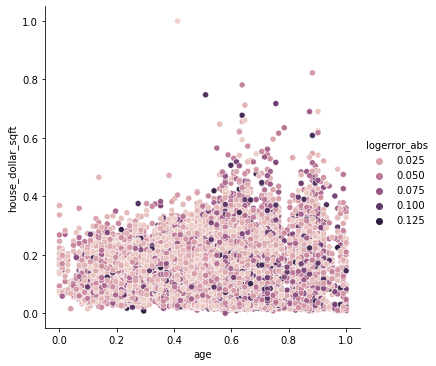

In [98]:
sns.relplot(data=X_train_scaled, x='age', y='house_dollar_sqft', hue=train.logerror_abs, kind='scatter')

### Takeaways:
- Cluster at High Age / Mid-Low HDSqft
- Clust at Mid-High Age / Mid HDSqft

### Visualize Log Error by Age vs Land Dollar per Sqft

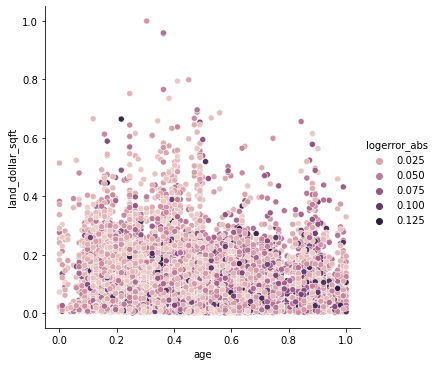

In [99]:
sns.relplot(data=X_train_scaled, x='age', y='land_dollar_sqft', hue=train.logerror_abs, kind='scatter')

### Takeaways:
- cluster at High Age / Low LDSqft

### Viz???

### Takeaways:
- ???

### Visualize Log Error by Age vs House Area by County

In [100]:
# sns.relplot(data=X_train_scaled, x='age', y='house_area', hue=train.logerror_abs, col='county', kind='scatter')

### Takeaways:
- LA has nothing.
- OC has Mid Age. 
- Ventura has Mid Age and High House Area

### Explore Log Error for Age vs Lot Area by County

In [101]:
# sns.relplot(data=X_train_scaled, x='age', y='lot_area', hue='logerror_abs', col='county', kind='scatter')

### Takeaways:
- LA has High Age and High Lot Area
- OC has Mid Age and High Lot Area
- Ventura has Mid to Low Age and High Lot Area

### Explore Log Error for House Area vs Lot Area by County

In [102]:
# sns.relplot(data=X_train_scaled, x='house_area', y='lot_area', hue='logerror_abs', col='county', kind='scatter')

### Takeaways:
- LA has nothing
- OC has Mid to High House Area and Mid to High Lot Area
- Ventura has Mid House Area and Mid to High Lot Area

### Explore Log Error for Age and Tax Value by County

In [103]:
# sns.relplot(data=X_train_scaled, x='age', y='tax_value_total', hue='logerror_abs', col='county', kind='scatter')

### Takeaways:
- LA has High Age
- OC Mid to Low Age
- Ventura Mid to Low Age

### Explore Log Error for House Area vs Tax Value by County

In [104]:
# sns.relplot(data=X_train_scaled, x='house_area', y='tax_value_total', hue='logerror_abs', col='county', kind='scatter')

### Takeaways:
- LA has nothing
- OC has Mid to High House Area and Mid to Low Tax Value
- Ventura has Mid House Area and Mid to Low Tax Value

### Explore Log Error for Lot Area vs Tax Value by County

In [105]:
# sns.relplot(data=X_train_scaled, x='lot_area', y='tax_value_total', hue='logerror_abs', col='county', kind='scatter')

### Takeaways:
- LA has nothing
- OC has nothing
- Ventura has Mid to High Lot Area and Mid to Low Tax Value

### Takeaways:
- cluster at High Age/ Low Dollar_sqft
- cluster at High Age / Mid Doloar Sqft
- Clust at Low Age / Low Dollar Sqft

### Visualize...

### Takeaways:
- Higher Log Error with Higher Age and Mid-Lower House Area

## <font color = 'red'>Elbow Method

In [106]:
X_train_scaled.drop(columns=['county'], inplace=True)

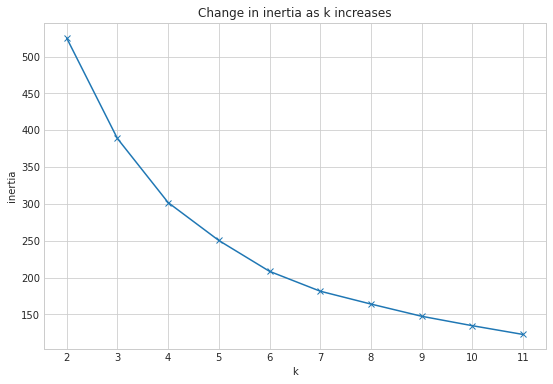

In [107]:
# Use elbow method to see if inertia values support our visual hunch that there are 5 clear groups
# lets plot inertia vs k

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k, random_state=123).fit(X_train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

### Takeaway:
- K vallues between 3 - 5
- Forward with k = 3

## <font color = 'red'>Cluster

In [108]:
X_train_scaled.head()

,house_dollar_sqft,land_dollar_sqft,age
7289,0.127935,0.053175,0.725490
20302,0.092248,0.042319,0.549020
47655,0.279664,0.070548,0.843137
6856,0.144486,0.075988,0.647059
31460,0.195595,0.084422,0.362745


In [109]:
# Move forward with k=3
kmeans = KMeans(n_clusters = 3, random_state=123)
kmeans.fit(X_train_scaled)

# And assign the cluster number to a column on the dataframe
train["cluster"] = kmeans.predict(X_train_scaled)
validate["cluster"] = kmeans.predict(X_validate_scaled)
test["cluster"] = kmeans.predict(X_test_scaled)
train.head()

,bathrooms,bedrooms,house_area,fips,full_baths,latitude,longitude,lot_area,land_use_code,city_id,...,logerror,heating_sys,age,logerror_abs,county,house_dollar_sqft,land_dollar_sqft,tax_rate,bed_bath_ration,cluster
7289,2.0,3.0,1214.0,6037.0,2.0,33941146.0,-118219071.0,4692.0,0100,47762.0,...,-0.021805,Floor/Wall,77.0,0.021805,LA,201.547776,23.466539,40.688882,1.5,0
20302,2.0,3.0,1398.0,6059.0,2.0,33806613.0,-117850438.0,6667.0,122,33252.0,...,-0.006413,None,59.0,0.006413,OC,146.867668,18.717114,33.621114,1.5,2
47655,1.0,2.0,864.0,6037.0,1.0,34164721.0,-118159711.0,11266.0,0100,47019.0,...,-0.081616,Floor/Wall,89.0,0.081616,LA,434.027778,31.066927,5.495448,2.0,0
6856,1.0,3.0,1006.0,6037.0,1.0,33873120.0,-118321763.0,5460.0,0100,54722.0,...,-0.048739,Floor/Wall,69.0,0.048739,LA,226.906561,33.447253,16.730565,3.0,2
31460,2.0,3.0,1802.0,6037.0,2.0,34114707.0,-117785574.0,9570.0,0100,39308.0,...,0.001546,Central,40.0,0.001546,LA,305.216426,37.136886,30.048996,1.5,1


In [110]:
train.cluster.value_counts()

2    9554
1    5227
0    2833
Name: cluster, dtype: int64

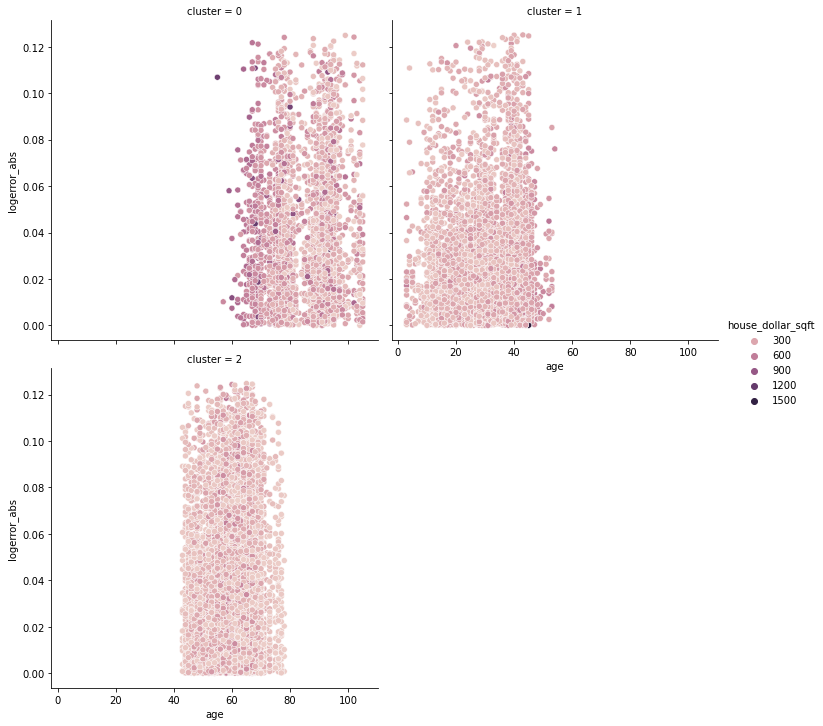

In [111]:
# show house dollar per sqft for age vs log error by cluster
sns.relplot(data=train, x="age", y="logerror_abs", col="cluster", hue='house_dollar_sqft', col_wrap=2)

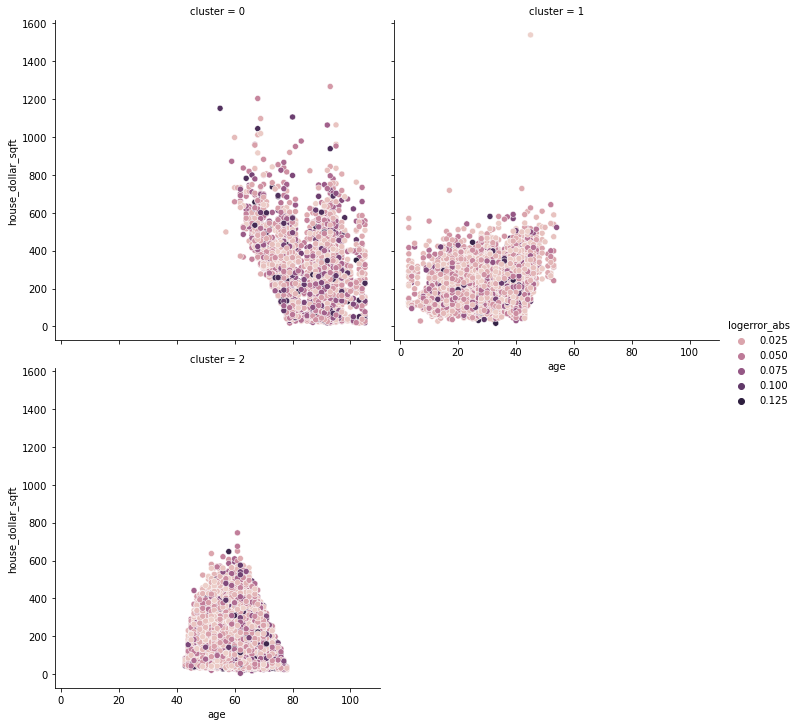

In [112]:
# show log error for age by house dollar per sqft by cluster
sns.relplot(data=train, x="age", y="house_dollar_sqft", col="cluster", hue="logerror_abs", col_wrap=2)

In [113]:
# show log error for tax value by lot area by cluster
# sns.relplot(data=train, x="age", y="house_area", col="cluster", hue="logerror_abs", col_wrap=2)

In [114]:
# show log error for tax value by lot area by cluster
#sns.relplot(data=X_train_scaled, x="tax_value_total", y="lot_area", col="cluster", hue="logerror_abs", col_wrap=2)

In [115]:
# show log error for tax value by lot area by cluster
# sns.relplot(data=X_train_scaled, x="tax_value_total", y="lot_area", col="cluster", hue="logerror_abs", col_wrap=2)

In [116]:
# show log error for tax value by lot area by cluster
# sns.relplot(data=X_train_scaled, x="tax_value_total", y="house_area", col="cluster", hue="logerror_abs", col_wrap=2)

In [117]:
# show log error for tax value by lot area by cluster
# sns.relplot(data=X_train_scaled, x="tax_value_total", y="age", col="cluster", hue="logerror_abs", col_wrap=2)

### Takeaways:
- cluster 2 shows highest log errors

### Check Significant Difference

In [118]:
# check mean of logerror for each cluster
train.groupby(by='cluster').logerror_abs.mean()

cluster
0    0.039055
1    0.027932
2    0.033515
Name: logerror_abs, dtype: float64

### Takeaways:
- Mean for cluster two is greater than the rest

### Run T-Test
- H0: Cluster 2 mean <= Overall Mean
- HA: Cluster 2 mean > Overall Mean 

In [119]:
# run one sample T-Test
alpha = 0.05
cluster_logerror = train[train.cluster==2].logerror_abs
overall_logerror = train.logerror_abs.mean()

t, p = stats.ttest_1samp(cluster_logerror, overall_logerror)
print(f't={t}, p={p/2}, alpha={alpha}')

t=2.709263691403143, p=0.0033776481750352944, alpha=0.05


### Takeaways:
- Since T > 0 and p < alpah, then reject Null Hypothesis. Cluster 2 Logerror is Significantly Greater than others

### ???

# <font color = 'red'> Prep for Modeling

In [120]:
train.columns.to_list()

['bathrooms',
 'bedrooms',
 'house_area',
 'fips',
 'full_baths',
 'latitude',
 'longitude',
 'lot_area',
 'land_use_code',
 'city_id',
 'county_id',
 'zip_id',
 'year_built',
 'tax_value_house',
 'tax_value_total',
 'tax_value_land',
 'tax_amount',
 'logerror',
 'heating_sys',
 'age',
 'logerror_abs',
 'county',
 'house_dollar_sqft',
 'land_dollar_sqft',
 'tax_rate',
 'bed_bath_ration',
 'cluster']

In [121]:
# hot one encode for cluster column using get_dummies for train, validate, test
df_dummies_train = pd.get_dummies(data=train.cluster, prefix='cluster', drop_first=True)
df_dummies_validate = pd.get_dummies(data=validate.cluster, prefix='cluster', drop_first=True)
df_dummies_test = pd.get_dummies(data=test.cluster, prefix='cluster', drop_first=True)

# concat df_dummies with train on columns
train = pd.concat([train, df_dummies_train], axis=1)
validate = pd.concat([validate, df_dummies_validate], axis=1)
test = pd.concat([test, df_dummies_test], axis=1)

train.head()

,bathrooms,bedrooms,house_area,fips,full_baths,latitude,longitude,lot_area,land_use_code,city_id,...,age,logerror_abs,county,house_dollar_sqft,land_dollar_sqft,tax_rate,bed_bath_ration,cluster,cluster_1,cluster_2
7289,2.0,3.0,1214.0,6037.0,2.0,33941146.0,-118219071.0,4692.0,0100,47762.0,...,77.0,0.021805,LA,201.547776,23.466539,40.688882,1.5,0,0,0
20302,2.0,3.0,1398.0,6059.0,2.0,33806613.0,-117850438.0,6667.0,122,33252.0,...,59.0,0.006413,OC,146.867668,18.717114,33.621114,1.5,2,0,1
47655,1.0,2.0,864.0,6037.0,1.0,34164721.0,-118159711.0,11266.0,0100,47019.0,...,89.0,0.081616,LA,434.027778,31.066927,5.495448,2.0,0,0,0
6856,1.0,3.0,1006.0,6037.0,1.0,33873120.0,-118321763.0,5460.0,0100,54722.0,...,69.0,0.048739,LA,226.906561,33.447253,16.730565,3.0,2,0,1
31460,2.0,3.0,1802.0,6037.0,2.0,34114707.0,-117785574.0,9570.0,0100,39308.0,...,40.0,0.001546,LA,305.216426,37.136886,30.048996,1.5,1,1,0


## <font color = 'red'>Select Columns

In [122]:
# select columns to model
cols = ['land_dollar_sqft','house_dollar_sqft', 'age', 'logerror_abs']

## <font color = 'red'> Create y_train and X_train sets

In [123]:
# establish target column
target = 'logerror_abs'

# create X & y version of train, validate, test with y the target and X are the features. 
X_train = train[cols].drop(columns=[target])
y_train = train[target]

X_validate = validate[cols].drop(columns=[target])
y_validate = validate[target]

X_test = test[cols].drop(columns=[target])
y_test = test[target]

In [124]:
X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

((17614, 3), (7550, 3), (6292, 3), (17614,), (7550,), (6292,))

## <font color = 'red'> Scale for Modeling

In [125]:
# Create the scale container
scaler = sklearn.preprocessing.MinMaxScaler()


# Fit the scaler to the features
scaler.fit(X_train)

# create scaled X versions 
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

# Convert numpy array to pandas dataframe for feature Engineering
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns.to_list())
X_validate_scaled = pd.DataFrame(X_validate_scaled, index=X_validate.index, columns=X_validate.columns.to_list())
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns.to_list())

In [126]:
X_train_scaled.head()

,land_dollar_sqft,house_dollar_sqft,age
7289,0.053175,0.127935,0.725490
20302,0.042319,0.092248,0.549020
47655,0.070548,0.279664,0.843137
6856,0.075988,0.144486,0.647059
31460,0.084422,0.195595,0.362745


## <font color = 'red'> Feature Engineering

### Use Select K Best to find 3 Best Features


In [127]:
from sklearn.feature_selection import SelectKBest, f_regression

# Use f_regression stats test each column to find best 3 features
f_selector = SelectKBest(f_regression, k=3)

# find tthe best correlations with y
f_selector.fit(X_train_scaled, y_train)

# Creaet boolean mask of the selected columns. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

f_feature

['land_dollar_sqft', 'house_dollar_sqft', 'age']

### Note:
- Select K Best selected area, year_built, and bathrooms.

### Use Recursive Feature Elemination to select 3 best features

In [128]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# create the ML algorithm container
lm = LinearRegression()

# create the rfe container with the the number of features I want. 
rfe = RFE(lm, n_features_to_select=3)

# fit RFE to the data
rfe.fit(X_train_scaled,y_train)  

# get the mask of the selected columns
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

rfe_feature

['land_dollar_sqft', 'house_dollar_sqft', 'age']

### Notes:
- RFE Select 3 Best Columns: area, latitude, longitude
- RFE Selects 3 best columns:land_dollar_sqft, house_dollar_sqft, age



In [129]:
X_train_scaled.head()

,land_dollar_sqft,house_dollar_sqft,age
7289,0.053175,0.127935,0.725490
20302,0.042319,0.092248,0.549020
47655,0.070548,0.279664,0.843137
6856,0.075988,0.144486,0.647059
31460,0.084422,0.195595,0.362745


In [130]:
# Remove Features before Modeling
# X_train_scaled = X_train_scaled.drop(columns=['pools','lot_size','bedrooms','bathrooms'])
# X_validate_scaled = X_validate_scaled.drop(columns=['pools','lot_size','bedrooms','bathrooms'])
# X_test_scaled = X_test_scaled.drop(columns=['pools','lot_size','bedrooms','bathrooms'])

# <font color = 'red'>Modeling

## Create Baseline & Evaluate with RMSE

In [131]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)
y_train.head()

,logerror_abs
7289,0.021805
20302,0.006413
47655,0.081616
6856,0.048739
31460,0.001546


In [132]:
# Add target mean column as baseline check
y_train['mean_pred'] = y_train.logerror_abs.mean()
y_validate['mean_pred'] = y_validate.logerror_abs.mean()

# add target median column as baseline check
y_train['median_pred'] = y_train.logerror_abs.median()
y_validate['median_pred'] = y_validate.logerror_abs.median()

In [133]:
# Create Baseline RMSE of target mean
rmse_train = mean_squared_error(y_train.logerror_abs, y_train.mean_pred) ** .5
rmse_validate = mean_squared_error(y_validate.logerror_abs, y_validate.mean_pred) ** .5

In [134]:
# Show RMSE Score for train and validate
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.03 
Validate/Out-of-Sample:  0.03


In [135]:
# Create Baseline RMSE of target median
rmse_train = mean_squared_error(y_train.logerror_abs, y_train.median_pred) ** .5
rmse_validate = mean_squared_error(y_validate.logerror_abs, y_validate.median_pred) ** .5

In [136]:
# Show RMSE Score for train and validate
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  0.03 
Validate/Out-of-Sample:  0.03


### Notes:
- Mean Baseline RMSE (.03) is same as Median Baseline RMSE (.03)
- Going Forward with Mean for Baseline

### Create Metric Holder

In [137]:
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])

In [138]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.028511,0.028382


## <font color = 'red'> Develop Models 

### Create Model 1 - Linear Regression (OLS) without Clusters

In [139]:
# create, fit, predict ols model for train and validate
ols = LinearRegression()
ols.fit(X_train_scaled, y_train.logerror_abs)
# predict for train
y_train['ols_pred_wo_cluster'] = ols.predict(X_train_scaled)
# predict validate
y_validate['ols_pred_wo_cluster'] = ols.predict(X_validate_scaled)

In [140]:
ols.coef_

array([-0.00320841, -0.0106081 ,  0.02050053])

In [141]:
y_train.head()

,logerror_abs,mean_pred,median_pred,ols_pred_wo_cluster
7289,0.021805,0.032749,0.025032,0.037457
20302,0.006413,0.032749,0.025032,0.034253
47655,0.081616,0.032749,0.025032,0.038204
6856,0.048739,0.032749,0.025032,0.035601
31460,0.001546,0.032749,0.025032,0.029203


In [142]:
X_train.head()

,land_dollar_sqft,house_dollar_sqft,age
7289,23.466539,201.547776,77.0
20302,18.717114,146.867668,59.0
47655,31.066927,434.027778,89.0
6856,33.447253,226.906561,69.0
31460,37.136886,305.216426,40.0


In [143]:
# evaluate rmse of train
rmse_train = mean_squared_error(y_train.logerror_abs, y_train.ols_pred_wo_cluster) ** .5

# evaluate rmse of validate
rmse_validate = mean_squared_error(y_validate.logerror_abs, y_validate.ols_pred_wo_cluster) ** .5

In [144]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.02712974396694978 
Validation/Out-of-Sample:  0.027103528466771193


In [145]:
# add to eval to metric holder
metric_df = metric_df.append({
    'model': 'ols_egressor_wo_cluster', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [146]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.028511,0.028382
1,ols_egressor_wo_cluster,0.027130,0.027104


In [147]:
y_train.head()

,logerror_abs,mean_pred,median_pred,ols_pred_wo_cluster
7289,0.021805,0.032749,0.025032,0.037457
20302,0.006413,0.032749,0.025032,0.034253
47655,0.081616,0.032749,0.025032,0.038204
6856,0.048739,0.032749,0.025032,0.035601
31460,0.001546,0.032749,0.025032,0.029203


### Create Model 2: Linear Regression (OLS) with Cluster Columns

In [148]:
# select columns to model including cluster columns
cols = ['land_dollar_sqft','house_dollar_sqft', 'age', 'logerror_abs', 'cluster_1', 'cluster_2']

In [149]:
X_train.head()

,land_dollar_sqft,house_dollar_sqft,age
7289,23.466539,201.547776,77.0
20302,18.717114,146.867668,59.0
47655,31.066927,434.027778,89.0
6856,33.447253,226.906561,69.0
31460,37.136886,305.216426,40.0


In [150]:
y_train.head()

,logerror_abs,mean_pred,median_pred,ols_pred_wo_cluster
7289,0.021805,0.032749,0.025032,0.037457
20302,0.006413,0.032749,0.025032,0.034253
47655,0.081616,0.032749,0.025032,0.038204
6856,0.048739,0.032749,0.025032,0.035601
31460,0.001546,0.032749,0.025032,0.029203


In [151]:
train.head()

,bathrooms,bedrooms,house_area,fips,full_baths,latitude,longitude,lot_area,land_use_code,city_id,...,age,logerror_abs,county,house_dollar_sqft,land_dollar_sqft,tax_rate,bed_bath_ration,cluster,cluster_1,cluster_2
7289,2.0,3.0,1214.0,6037.0,2.0,33941146.0,-118219071.0,4692.0,0100,47762.0,...,77.0,0.021805,LA,201.547776,23.466539,40.688882,1.5,0,0,0
20302,2.0,3.0,1398.0,6059.0,2.0,33806613.0,-117850438.0,6667.0,122,33252.0,...,59.0,0.006413,OC,146.867668,18.717114,33.621114,1.5,2,0,1
47655,1.0,2.0,864.0,6037.0,1.0,34164721.0,-118159711.0,11266.0,0100,47019.0,...,89.0,0.081616,LA,434.027778,31.066927,5.495448,2.0,0,0,0
6856,1.0,3.0,1006.0,6037.0,1.0,33873120.0,-118321763.0,5460.0,0100,54722.0,...,69.0,0.048739,LA,226.906561,33.447253,16.730565,3.0,2,0,1
31460,2.0,3.0,1802.0,6037.0,2.0,34114707.0,-117785574.0,9570.0,0100,39308.0,...,40.0,0.001546,LA,305.216426,37.136886,30.048996,1.5,1,1,0


In [152]:
# establish target column
target = 'logerror_abs'

# create X & y version of train, validate, test with y the target and X are the features. 
X_train = train[cols].drop(columns=[target])

X_validate = validate[cols].drop(columns=[target])

X_test = test[cols].drop(columns=[target])

In [153]:
y_train.head()

,logerror_abs,mean_pred,median_pred,ols_pred_wo_cluster
7289,0.021805,0.032749,0.025032,0.037457
20302,0.006413,0.032749,0.025032,0.034253
47655,0.081616,0.032749,0.025032,0.038204
6856,0.048739,0.032749,0.025032,0.035601
31460,0.001546,0.032749,0.025032,0.029203


In [154]:
# Create the scale container
scaler = sklearn.preprocessing.MinMaxScaler()


# Fit the scaler to the features
scaler.fit(X_train)

# create scaled X versions 
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

# Convert numpy array to pandas dataframe for feature Engineering
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns.to_list())
X_validate_scaled = pd.DataFrame(X_validate_scaled, index=X_validate.index, columns=X_validate.columns.to_list())
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns.to_list())

In [155]:
y_train.head()

,logerror_abs,mean_pred,median_pred,ols_pred_wo_cluster
7289,0.021805,0.032749,0.025032,0.037457
20302,0.006413,0.032749,0.025032,0.034253
47655,0.081616,0.032749,0.025032,0.038204
6856,0.048739,0.032749,0.025032,0.035601
31460,0.001546,0.032749,0.025032,0.029203


In [156]:
# create, fit, predict ols model for train and validate
ols = LinearRegression()
ols.fit(X_train_scaled, y_train.logerror_abs)

# predict on train
y_train['ols_pred_w_cluster'] = ols.predict(X_train_scaled)

# predict validate
y_validate['ols_pred_w_cluster'] = ols.predict(X_validate_scaled)

In [157]:
# evaluate rmse for train
rmse_train = mean_squared_error(y_train.logerror_abs, y_train.ols_pred_w_cluster) ** .5

# evaluate rmse for validate
rmse_validate = mean_squared_error(y_validate.logerror_abs, y_validate.ols_pred_w_cluster) ** .5

In [158]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.027122581357423823 
Validation/Out-of-Sample:  0.027091822194969153


In [159]:
# add to eval to metric holder
metric_df = metric_df.append({
    'model': 'ols_egressor_w_cluster', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [160]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.028511,0.028382
1,ols_egressor_wo_cluster,0.027130,0.027104
2,ols_egressor_w_cluster,0.027123,0.027092


### Takeaways:
- With clusters did worse

###  Create Model 3: Linear Regression (OLS) with Clusters and More Features

In [161]:
train.columns.to_list()

['bathrooms',
 'bedrooms',
 'house_area',
 'fips',
 'full_baths',
 'latitude',
 'longitude',
 'lot_area',
 'land_use_code',
 'city_id',
 'county_id',
 'zip_id',
 'year_built',
 'tax_value_house',
 'tax_value_total',
 'tax_value_land',
 'tax_amount',
 'logerror',
 'heating_sys',
 'age',
 'logerror_abs',
 'county',
 'house_dollar_sqft',
 'land_dollar_sqft',
 'tax_rate',
 'bed_bath_ration',
 'cluster',
 'cluster_1',
 'cluster_2']

In [162]:
# select columns to model including cluster columns
cols = ['land_dollar_sqft','house_dollar_sqft', 'age', 'logerror_abs', 'cluster_1', 'cluster_2', 'longitude',
       'latitude','bed_bath_ration','tax_rate']

In [163]:
# establish target column
target = 'logerror_abs'

# create X & y version of train, validate, test with y the target and X are the features. 
X_train = train[cols].drop(columns=[target])

X_validate = validate[cols].drop(columns=[target])

X_test = test[cols].drop(columns=[target])

In [164]:
# Create the scale container
scaler = sklearn.preprocessing.MinMaxScaler()


# Fit the scaler to the features
scaler.fit(X_train)

# create scaled X versions 
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

# Convert numpy array to pandas dataframe for feature Engineering
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns.to_list())
X_validate_scaled = pd.DataFrame(X_validate_scaled, index=X_validate.index, columns=X_validate.columns.to_list())
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns.to_list())

In [165]:
# create, fit, predict ols model for train and validate
ols = LinearRegression()
ols.fit(X_train_scaled, y_train.logerror_abs)

# predict on train
y_train['ols_pred_w_cluster_and_features'] = ols.predict(X_train_scaled)

# predict validate
y_validate['ols_pred_w_cluster_and_features'] = ols.predict(X_validate_scaled)

In [166]:
# evaluate rmse for train
rmse_train = mean_squared_error(y_train.logerror_abs, y_train.ols_pred_w_cluster_and_features) ** .5

# evaluate rmse for validate
rmse_validate = mean_squared_error(y_validate.logerror_abs, y_validate.ols_pred_w_cluster_and_features) ** .5

In [167]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.02711133086734984 
Validation/Out-of-Sample:  0.02707856984889547


In [168]:
# add to eval to metric holder
metric_df = metric_df.append({
    'model': 'ols_egressor_w_cluster_and_features', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [169]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.028511,0.028382
1,ols_egressor_wo_cluster,0.027130,0.027104
2,ols_egressor_w_cluster,0.027123,0.027092
3,ols_egressor_w_cluster_and_features,0.027111,0.027079


### Takeaways:
- ???

### Create Model 4 - Polynomial Regression with Clusters and More Features

In [170]:
# create polynomial features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled to new sets
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 =  pf.transform(X_test_scaled)

In [171]:
# create the model object
osl2 = LinearRegression()

# fit the model train data. Specify y_train columns since it was converted to dataframe  
osl2.fit(X_train_degree2, y_train.logerror_abs)

# predict train
y_train['pr_pred'] = osl2.predict(X_train_degree2)

# create rmse
rmse_train = mean_squared_error(y_train.logerror_abs, y_train.pr_pred) ** .5

# predict validate
y_validate['pr_pred'] = osl2.predict(X_validate_degree2)

# evaluate rmse
rmse_validate = mean_squared_error(y_validate.logerror_abs, y_validate.pr_pred) ** .5

In [172]:
print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.026979929952927608 
Validation/Out-of-Sample:  0.027079308883026645


In [173]:
# add to metric holder
metric_df = metric_df.append({
    'model': 'PolynomialRegressor', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [174]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.028511,0.028382
1,ols_egressor_wo_cluster,0.027130,0.027104
2,ols_egressor_w_cluster,0.027123,0.027092
3,ols_egressor_w_cluster_and_features,0.027111,0.027079
4,PolynomialRegressor,0.026980,0.027079


## <font color = 'red' > Evaluate
    
### Plotting Actual vs Predicted Values

In [175]:
y_train.head()

,logerror_abs,mean_pred,median_pred,ols_pred_wo_cluster,ols_pred_w_cluster,ols_pred_w_cluster_and_features,pr_pred
7289,0.021805,0.032749,0.025032,0.037457,0.038883,0.039134,0.035066
20302,0.006413,0.032749,0.025032,0.034253,0.033910,0.033576,0.032347
47655,0.081616,0.032749,0.025032,0.038204,0.038967,0.038658,0.042979
6856,0.048739,0.032749,0.025032,0.035601,0.034837,0.034391,0.035237
31460,0.001546,0.032749,0.025032,0.029203,0.029013,0.028212,0.025927


In [176]:
adsfasdfads

NameError: name 'adsfasdfads' is not defined

In [ ]:
plt.figure(figsize=(10,5))

#Basline
plt.plot(y_validate.logerror_abs, y_validate.mean_pred, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))

# Ideal Line
plt.plot(y_validate.logerror_abs, y_validate.logerror_abs, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=20)

# Model 1: OLS without Clusters
plt.scatter(y_validate.logerror_abs, y_validate.ols_pred_wo_cluster, 
            alpha=.5, color="red", s=100, label="Model 1: OLS wo Clusters")

# Model 2: OlS with Clusters
plt.scatter(y_validate.logerror_abs, y_validate.ols_pred_w_cluster, 
            alpha=.5, color="yellow", s=100, label="Model 2: OLS w Clusters")

# Model 3: OLS with Clusters and More Features
plt.scatter(y_validate.logerror_abs, y_validate.ols_pred_w_cluster_and_features, 
            alpha=.5, color="green", s=100, label="Model 3: OLS w Clusters and More Features")

# # Model 4: Polynomial Regresion with Clusters and More Features
# plt.scatter(y_validate.logerror_abs, y_validate.pr_pred, 
#             alpha=.5, color="brown", s=100, label="Model 4: Poly Regression with Clusters and More Features")



# plt.legend()
# plt.xlabel("Actual Tax Value")
# plt.ylabel("Predicted Tax Value")
# plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Notes:
- ????

### Residual Plots: Plotting the Errors in Predictions

In [ ]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.ols_pred - y_validate.tax_value , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.glm_pred - y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.lm2_pred - y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value")
# plt.title("Do the size of errors change as the actual value changes?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Notes:
- ???

### Histograms of Actuals vs Predicted Values

In [ ]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Tax Values")
plt.hist(y_validate.ols_pred, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.glm_pred, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.lm2_pred, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Values")
plt.ylabel("Number of Homes ")
plt.title("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Tax Values for the Top Models")
plt.legend()
plt.show()

### Notes:
- Models capture most of actual values distribution but miss the lower valued homes

## Model Selection and Out-of-Sample Evaluatoin

In [ ]:
# predict train
y_test['lm2_pred'] = lm2.predict(X_test_degree2)

# create rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.lm2_pred) ** .5

print("RMSE for Polynomial Model, degrees=2\nTest/Out-of-Sample: ", rmse_test)# add to metric holder

In [ ]:
metric_df

### Notes:
- Polynomial Model RMSE is 18.6M indicating wrong model to use and/or overfit

### Check with OLS

In [ ]:
# predict test
y_test['ols_pred'] = ols.predict(X_test_scaled)

# evaluate rmse of train and validate
rmse_test = mean_squared_error(y_test.tax_value, y_test.ols_pred) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_test)

### Note:
- OLS performed worse than baseline on test data set

# <font color = 'red'> Conclusion

## Summary
- 

## Recommendations
- ???

## Conclusion
- ???

### Project Description

- A model that predicts property tax assessed values of single family properties based on 2017 transactions.
- Identify ways to make a better model for Zillow.
- Create new features out of existing features.
- Try non-linear regression model or try a model for each count

Deliver:
1. Github Repo
    - README.md
    - Final Report
    - Working Notebooks
    - Acquire and Prepare Modules
    - Misc Artifacts
1. Regression Model (Linear or Non-Linear)
2. Final Notebook with Recommendation
    - 4 Visuals, 2 with stats tests
        - Data Context of Target Variable (Distribution of values)
    - 3 Best Models (show steps/code to fit/eval/select)
    - Visual of how best Model performed
3. Working Notebook:
    - Reproducible comments
    - Exploration with at least two stats test during exploration
5. Presentation
    - Findings
    - Methodologies
    - Conclusions

### Initial Questions

- What are the transactions are in 2017?
- What states and counties are the properties located in?
- What is the tax rate per county or fips? (might have to combine columns to calcualate)
- What is the distribution of tax rates for each county?
- What is the distribution of taxes across fips?
- What are the drivers of single family property values?
- Why do some properties have a much higher value than others when they are located so close to each other?
- Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? 
- Is having 1 bathroom worse than having 2 bedrooms?

## Live Presentation

- intro (live)
- audience & setting  (live)
- content (live)
- Verbal Conclusion (findings, next steps, recommendations)  (live) 
- time (live) 

## Deliver Predictions
- Deliver predictions (.csv) 